In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')
from model import UMI, UMI_L1, UMI_L2, UMI_SVB, UMI_SVB_soft, UMI_big, UMI_bigger, UMI_Jacobi, UMI_Jacobi_2, UMI_Jacobi_flip
from Animation import AnimatedScatter
from datagen import DataGen

c:\Users\matti\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data generation

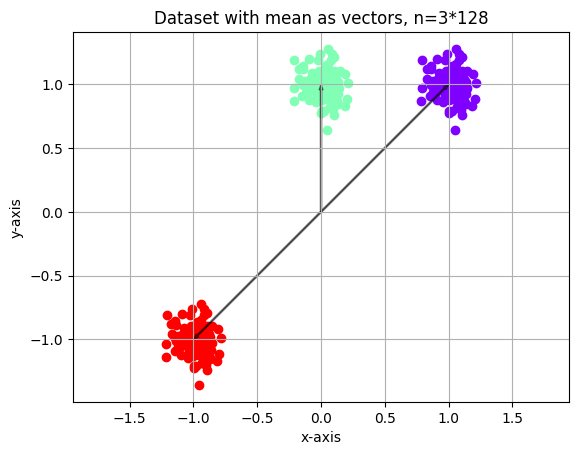

In [2]:
n_categories = 3
n_p = 128 # points_per_category


# sym, as, as_extra, parallel, manual
datatype = "manual"
as_pos = np.array([[1,1],[0,1],[-1,-1]])
dataclass = DataGen(n_categories, n_p, scale=1, name=datatype, seed=1234, as_pos=as_pos)
centers,data,labels = dataclass.centers,dataclass.data,dataclass.labels

dataclass.plot()


# centers,data,labels = data_gen(n_categories,n_p,scale=1)
# centers,data,labels = data_gen_as_extra(n_categories,n_p,scale=1)

### Putting data in PyTorch dataset

In [3]:
class ScatterData(Dataset):
    def __init__(self,points,labels,n_cat):
        self.x = torch.tensor(points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [4]:
BATCH_SIZE = 32

training_data = ScatterData(data,labels,n_categories)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

### Create model

In [27]:
# model = UMI_L2(2,n_categories,lr=1e-3)
model = UMI_Jacobi_flip(2,n_categories,lr=0.1,bias=False,decay=50.0)

# summary(model,input_size=(1,2))

In [28]:
print(training_data[0][0])

tensor([1.0471, 0.8809])


In [29]:
model.flip(training_data[0:10][0],training_data[0:10][1])

### Training

In [30]:
w_his = []

In [31]:
def train(loader,model,n_epochs=5):
    """Network training function

    Arguments:
        loader -- pytorch dataloader object of training data
        model -- pytorch nn object, neural network model

    Keyword Arguments:
        n_epochs -- number of epochs for training (default: {5})

    Returns:
        epochs, losses -- numpy arrays of epoch numbers (with decimals representing each batch) and loss values for each batch
    """
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses)

# Trainer for hard SVB
def train_SVB(loader,model,n_epochs=5):
    """Network training function for hard SVB
    """
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        model.SVB(eps=0.001)
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses)

In [32]:
def train_jacobi(loader,model,n_epochs=5):
    """Network training function for Jacobi
    """
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses), np.array(model.cross_losses), np.array(model.jacobi_losses)

def train_jacobi_flip(loader,model,n_epochs=5):
    """Network training function for Jacobi
    """
    j = 0
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        j += 1
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            if j%2 == 0:
                model.flip(inputs,labels)
            loss = model.train_step(inputs,labels)
            model.flip(loader.dataset.x,loader.dataset.y)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses), np.array(model.cross_losses), np.array(model.jacobi_losses)

In [33]:
# epoch_data, loss_data = train(training_loader,model,n_epochs=250)
# epoch_data, loss_data, crossloss_data, jacobiloss_data = train_jacobi(training_loader,model,n_epochs=500)
epoch_data, loss_data, crossloss_data, jacobiloss_data = train_jacobi_flip(training_loader,model,n_epochs=500)
# epoch_data, loss_data = train_SVB(training_loader,model,n_epochs=500)

12it [00:00, 279.15it/s]00:00<?, ?it/s]
12it [00:00, 228.52it/s]
12it [00:00, 285.51it/s]00:00<00:25, 19.81it/s]
12it [00:00, 242.37it/s]
12it [00:00, 285.70it/s]
12it [00:00, 235.32it/s]00:00<00:24, 20.45it/s]
12it [00:00, 321.19it/s]
12it [00:00, 243.84it/s]
12it [00:00, 337.96it/s]00:00<00:24, 20.49it/s]
12it [00:00, 228.31it/s]
12it [00:00, 347.77it/s]
12it [00:00, 216.66it/s][00:00<00:22, 21.31it/s]
12it [00:00, 286.17it/s]
12it [00:00, 262.03it/s]
12it [00:00, 338.42it/s][00:00<00:23, 20.62it/s]
12it [00:00, 230.78it/s]
12it [00:00, 347.62it/s]
12it [00:00, 242.18it/s][00:00<00:22, 21.33it/s]
12it [00:00, 319.87it/s]
12it [00:00, 225.43it/s]
12it [00:00, 289.05it/s][00:00<00:23, 20.81it/s]
12it [00:00, 226.43it/s]
12it [00:00, 303.78it/s]
12it [00:00, 224.59it/s][00:01<00:23, 20.72it/s]
12it [00:00, 290.56it/s]
12it [00:00, 259.49it/s]
12it [00:00, 296.02it/s][00:01<00:23, 20.39it/s]
12it [00:00, 260.87it/s]
12it [00:00, 328.54it/s]
12it [00:00, 252.87it/s][00:01<00:22, 21.05it/s

### Training results visualization

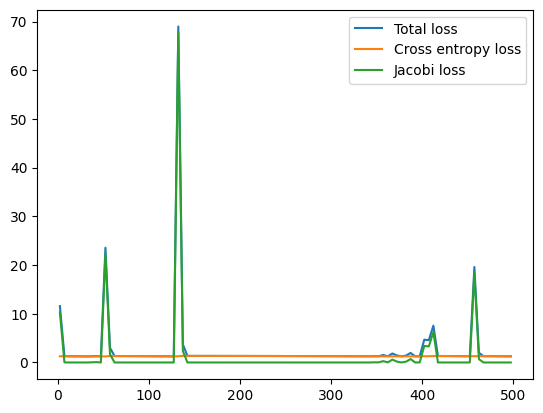

In [34]:
epoch_data_avgd = epoch_data.reshape(100,-1).mean(axis=1) # the number in reshape has to divide the number of epochs
loss_data_avgd = loss_data.reshape(100,-1).mean(axis=1)

plt.plot(epoch_data_avgd,loss_data_avgd, label="Total loss") # Plot the average loss per epoch

crossloss_data_avgd = crossloss_data[:].reshape(100,-1).mean(axis=1)
jacobiloss_data_avgd = jacobiloss_data[:].reshape(100,-1).mean(axis=1)
plt.plot(epoch_data_avgd,crossloss_data_avgd,label="Cross entropy loss") # Plot the average loss per epoch
plt.plot(epoch_data_avgd,jacobiloss_data_avgd, label="Jacobi loss") # Plot the average loss per epoch
# plt.plot(epoch_data,loss_data)

plt.legend()

### Testing

In [35]:
# t_centers, test_data, test_labels = data_gen_as_extra(n_categories,512)

test_n = 512
test_data = DataGen(n_categories, test_n, scale=1, name=datatype, seed=3141, as_pos=as_pos)
t_centers, test_data, test_labels = test_data.centers,test_data.data,test_data.labels
test_set = ScatterData(test_data,test_labels,n_categories)

acc = (model(test_set.x).argmax(dim=1) == test_set.y.argmax(dim=1)).float().sum().item()/len(test_set)
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.00


### Weights

[Parameter containing:
tensor([[-0.0364, -0.2666],
        [ 0.0335, -1.0445],
        [ 0.9345, -0.3714]], requires_grad=True)]


(-1.3361432383955467,
 1.3337269234905411,
 -1.487988469764845,
 1.408021211687328)

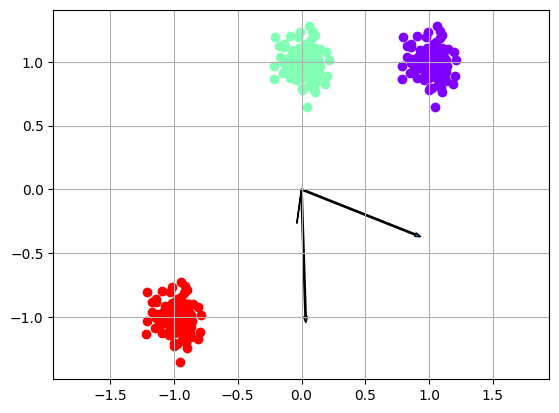

In [36]:
w = []

for param in model.parameters():
    w.append(param)
    print(w)

w_np = w[0].detach().numpy()
if len(w) > 1:
    bias = w[1].detach().numpy()

for w in w_np:
    w_len = np.linalg.norm(w)
    width = 0.01*w_len
    plt.arrow(0,0,w[0],w[1],length_includes_head=True,width=width)

colors = cm.rainbow(np.linspace(0,1,n_categories))

for col,center,i in zip(colors,centers,range(n_categories)):
    plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
    # plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

plt.grid()
plt.axis('equal')

In [24]:
loss_data[::16].shape

(375,)

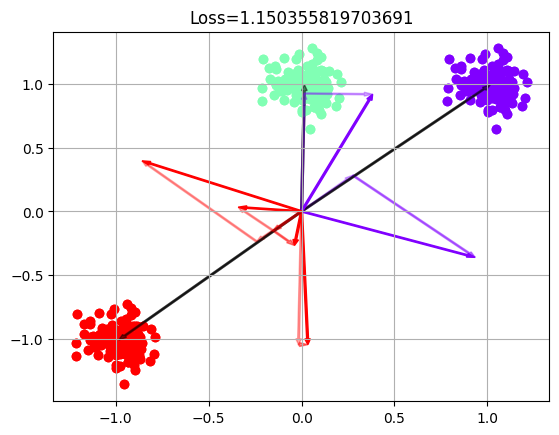

In [37]:
w_his = np.array(w_his)

animated_scatter = AnimatedScatter(data,w_his.transpose([0,2,1]),loss_data,n_clusters=n_categories,acc=acc)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object